In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
from astropy.io import fits
import numpy as np
from pyrafspec.fitslist import *
import matplotlib.pyplot as plt
from pyrafspec import splicing_spectrum
from pyrafspec.bfosclog import *
import pyrafspec.bfosce9g10 as bfosce9g10
import os
from astropy.time import Time
from astropy import constants, units
from PyAstronomy import pyasl
from astropy import coordinates as coord
from pyrafspec.spec_tools import rvcorr_spec
from pyrafspec.lighttraveltime import rv2baryrv
from laspec import normalization as lanorm
from PyAstronomy import pyasl
import joblib
import collections
from astropy.table import Table, vstack
from tqdm import tqdm
plt.style.use('lijiaostyle')

In [8]:
from glob import glob

dires = ['20201215', '20201218','20201219','20210225','20210304','20210307','20210316','20210321','20210323','20210424','20210425',
         '20210504','20210505', '20210508', '20210601', '20210602', '20210603', '20211022', '20211023', '20211024', '20211113', '20211114']

tab_rv = Table.read('/home/lcq/media/backup/216BFOSC/sdOB_216/20201215_bfosc/rv_tab.csv')
for _dire in dires:
    print(_dire)
    dire = f'/home/lcq/media/backup/216BFOSC/sdOB_216/{_dire}_bfosc/'
    _fname = f'{dire}/rv_tab.csv'
    _tab = Table.read(_fname)
    tab_rv = vstack([tab_rv, _tab])

20201215
20201218
20201219
20210225
20210304
20210307
20210316
20210321
20210323
20210424
20210425
20210504
20210505
20210508
20210601
20210602
20210603
20211022
20211023
20211024
20211113
20211114


# internal [crossmatch](http://www.star.bris.ac.uk/~mbt/stilts/#commands) the radial velocity table

In [ ]:
direout = '/home/sdb216/sdOBdata/216BFOSC/'
filename = os.path.join(direout, 'rvtab.fits')
fileout = os.path.join(direout, 'rvtab_group.fits')
tab_rv.write(filename, overwrite=True)

command = 'java -jar /home/sdb216/sdOBdata/Documents/programs/stilts.jar tmatch1\
           matcher=sky values="ra_deg dec_deg" params=5 \
           action=identify\
           in={0}\
           out={1} \
           '.format(filename, fileout)
os.system(command)

In [69]:
def getmaxdrv(rvs):
    rvs = np.where(np.abs(rvs) > 3000, np.nan, rvs)
    maxdrv = np.nanmax(rvs) - np.nanmin(rvs)
    return maxdrv

In [ ]:
data = Table.read(fileout)


delta_halpha = np.zeros(len(data))
delta_hbeta = np.zeros_like(delta_halpha)
delta_hgamma = np.zeros_like(delta_halpha)
delta_ccf = np.zeros_like(delta_halpha)
for GroupID in np.arange(1, 69):
    ind = data['GroupID'] == GroupID
    delta_ccf[ind] = getmaxdrv(data['rv_ccf'][ind])
    delta_halpha[ind] = getmaxdrv(data['rv_halpha'][ind])
    delta_hbeta[ind] = getmaxdrv(data['rv_hbeta'][ind])
    delta_hgamma[ind] = getmaxdrv(data['rv_hgamma'][ind])
    
_tmptab = Table(data=[delta_ccf, delta_halpha, delta_hbeta, delta_hgamma], names=['delta_ccf', 'delta_halpha', 'delta_hbeta', 'delta_hgamma'])

tab = hstack([data, _tmptab])

radial velocity standard stars:

- [BD+25 4655](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=%401498743&Name=BD%2b25%20%204655&submit=submit) HIP 108578
- - ra, dec = 329.9248964540986, +26.4326106545684

- [HR 718](http://simbad.u-strasbg.fr/simbad/sim-basic) HIP 11484, HD 15318   [Pulkovo radial velocities for 35493 HIP stars](https://cdsarc.cds.unistra.fr/viz-bin/cat/III/252#/browse)
- - ra, dec = 037.0398210789746, +08.4600602248073

- [Gaia DR2 radial velocity standard stars catalog](https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/616/A7#/browse)

- [eso Spectrophotometric Standards](http://www.eso.org/sci/observing/tools/standards/spectra/stanlis.html)

In [25]:
def plot_spectra(filelist, dire=None, dflux=0.1, ax =None, **keywords):
    if ax is None:
       fig, ax = plt.subplots(1,1,figsize=[13,4])
    for i, _fname in enumerate(filelist):
        _dire = os.path.join(dire, _fname[0:8]+'_bfosc')
        fname = os.path.join(_dire, _fname)
        data = fits.getdata(fname,1)
        wave = 10**data['loglambda_bary']
        flux = data['flux']
        err = data['error']
        plt.plot(wave, flux+i*dflux, **keywords)
    return ax

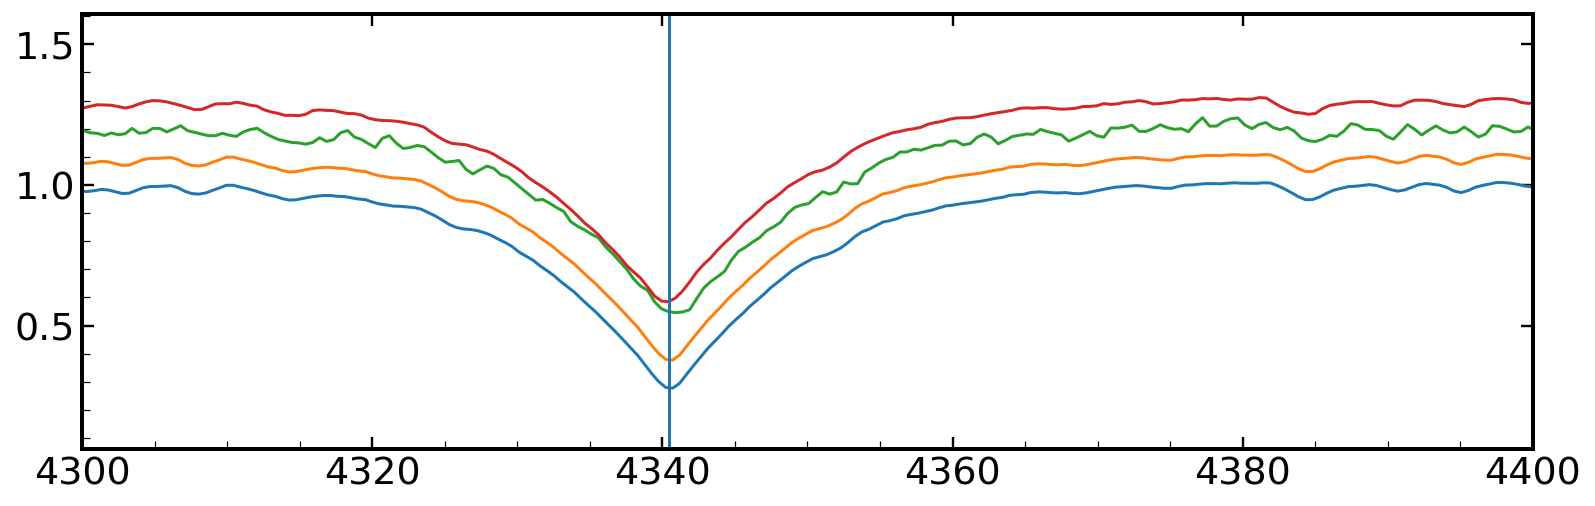

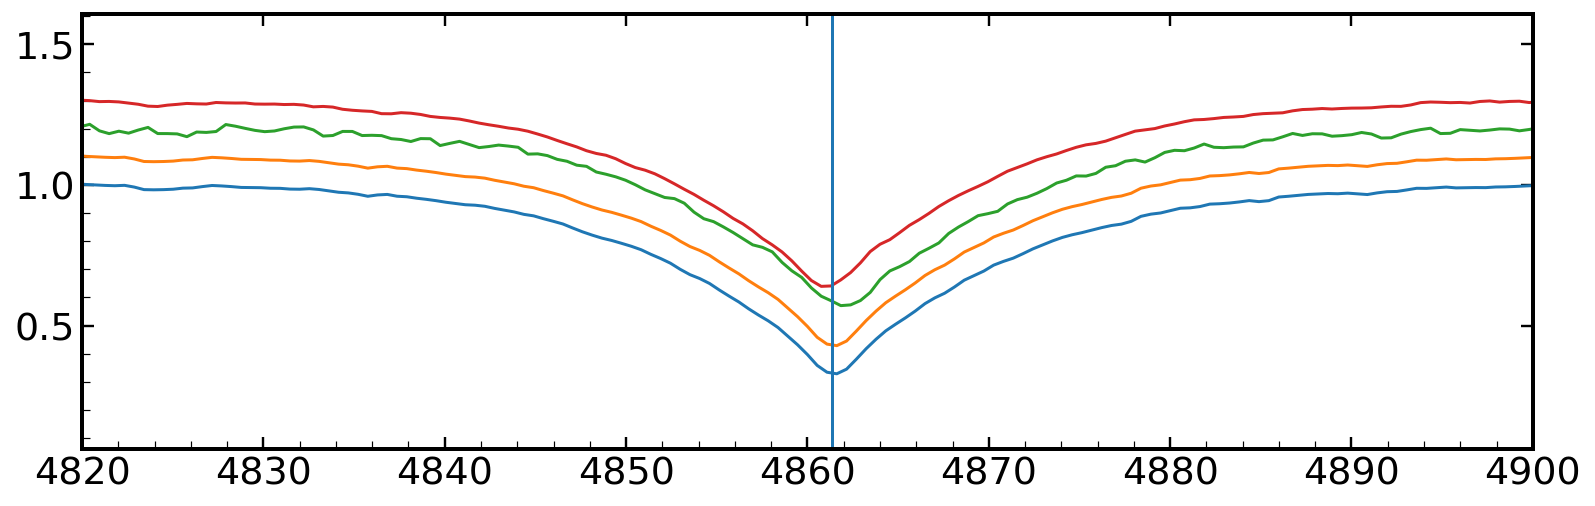

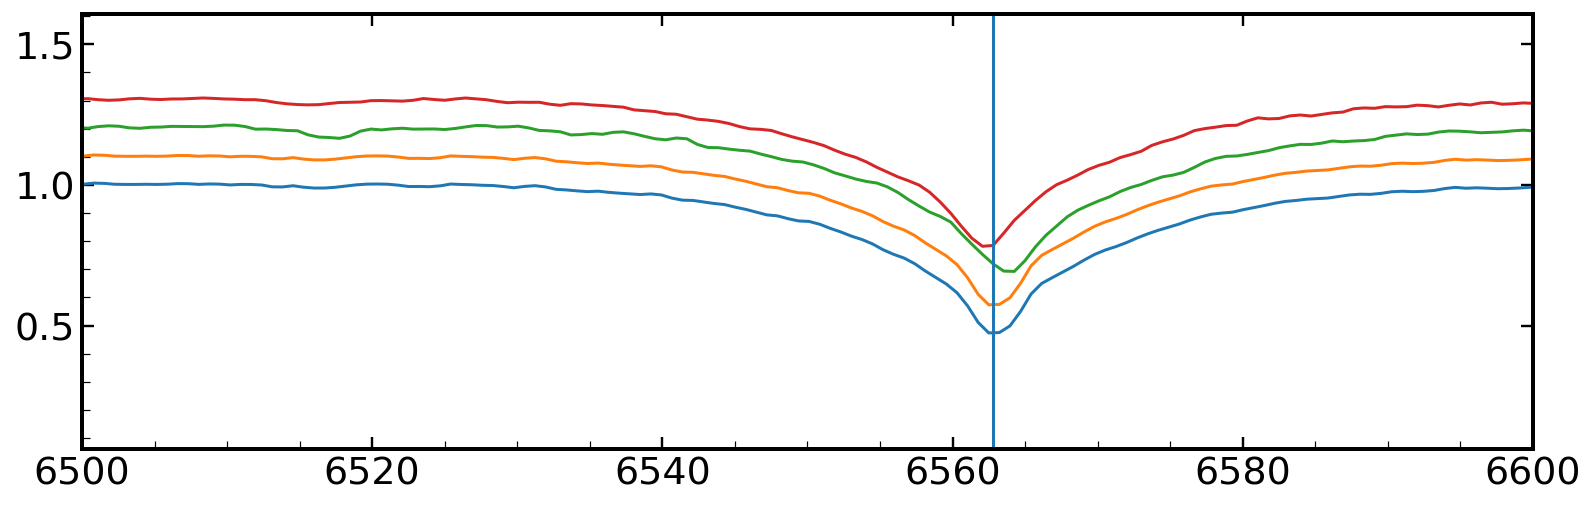

In [67]:
#HR 718 HIP 11484, HD 15318 
ra, dec = 037.0398210789746, +08.4600602248073
angdist2BD = pyasl.getAngDist(ra, dec, tab_rv['ra_deg'], tab_rv['dec_deg'])
ind = angdist2BD < 50/3600
tab_rv[ind]
lam0 = 6562.79
m0=4861.35
lam0=4340.46 
fig, ax = plt.subplots(1,1,figsize=[13,4])
ax = plot_spectra(tab_rv[ind]['basename'], dire = '/home/lcq/media/backup/216BFOSC/sdOB_216/', ax=ax)
plt.xlim(4300, 4400)
plt.axvline(x=4340.46)
fig, ax = plt.subplots(1,1,figsize=[13,4])
ax = plot_spectra(tab_rv[ind]['basename'], dire = '/home/lcq/media/backup/216BFOSC/sdOB_216/', ax=ax)
plt.xlim(4820, 4900)
plt.axvline(x=4861.35)
fig, ax = plt.subplots(1,1,figsize=[13,4])
ax = plot_spectra(tab_rv[ind]['basename'], dire = '/home/lcq/media/backup/216BFOSC/sdOB_216/', ax=ax)
plt.xlim(6500, 6600)
plt.axvline(x=6562.79)

In [68]:
tab_rv[ind]

basename,bjd,ra,dec,ra_deg,dec_deg,flamp,rms_lamp,rv_ccf,err_ccf,rv_halpha,rverr_halpha,rv_hbeta,rverr_hbeta,rv_hgamma,rverr_hgamma
str73,float64,str11,str12,float64,float64,str48,float64,float64,float64,float64,float64,float64,float64,float64,float64
20201215-0024_splicing.fits,2459198.970677091,02:28:09.00,+08:27:36.0,37.0375,8.46,20201215-0025,0.04825571176516848,10.0,0.68520963,5.031567,1.2529854,8.724735,1.0265647,4.6454754,1.2446339
20201215-0024_splicing.fits,2459198.970677091,02:28:09.00,+08:27:36.0,37.0375,8.46,20201215-0025,0.04825571176516848,10.0,0.68520963,5.031567,1.2529854,8.724735,1.0265647,4.6454754,1.2446339
202111130063_SPECSTARGET_HR718_slit16s_G10_E9_splicing.fits,2459532.315829586,02:28:09.5,+08:27:36.22,37.039585,8.460061,202111130064_SPECSLAMP_FeAr_slit16s_G10_E9,0.06560504534811956,40.0,7.71313,39.13272,2.053297,42.191364,1.8964154,31.263817,2.8545072
202111140060_SPECSTARGET_HR718_slit16s_G10_E9_splicing.fits,2459533.185020043,02:28:09.5,+08:27:36.22,37.039585,8.460061,202111140061_SPECSLAMP_FeAr_slit16s_G10_E9,0.07175333667701979,-10.0,0.0,-18.807222,1.5123209,-14.4591675,0.9689476,-15.192435,1.2767231


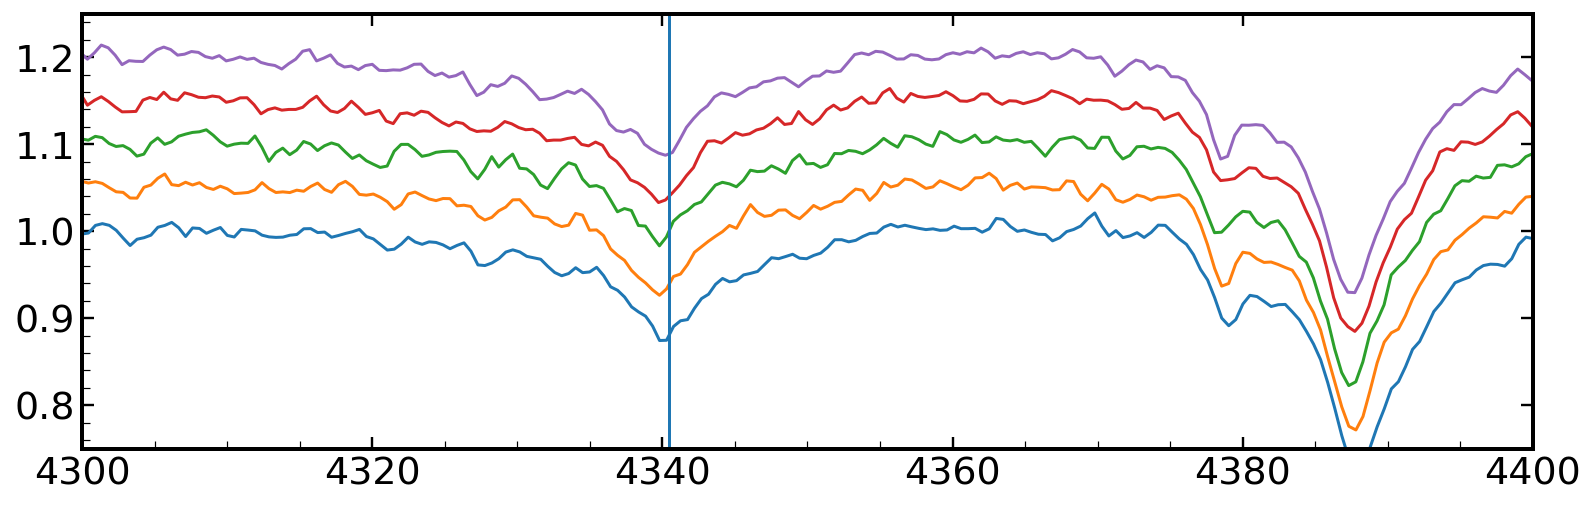

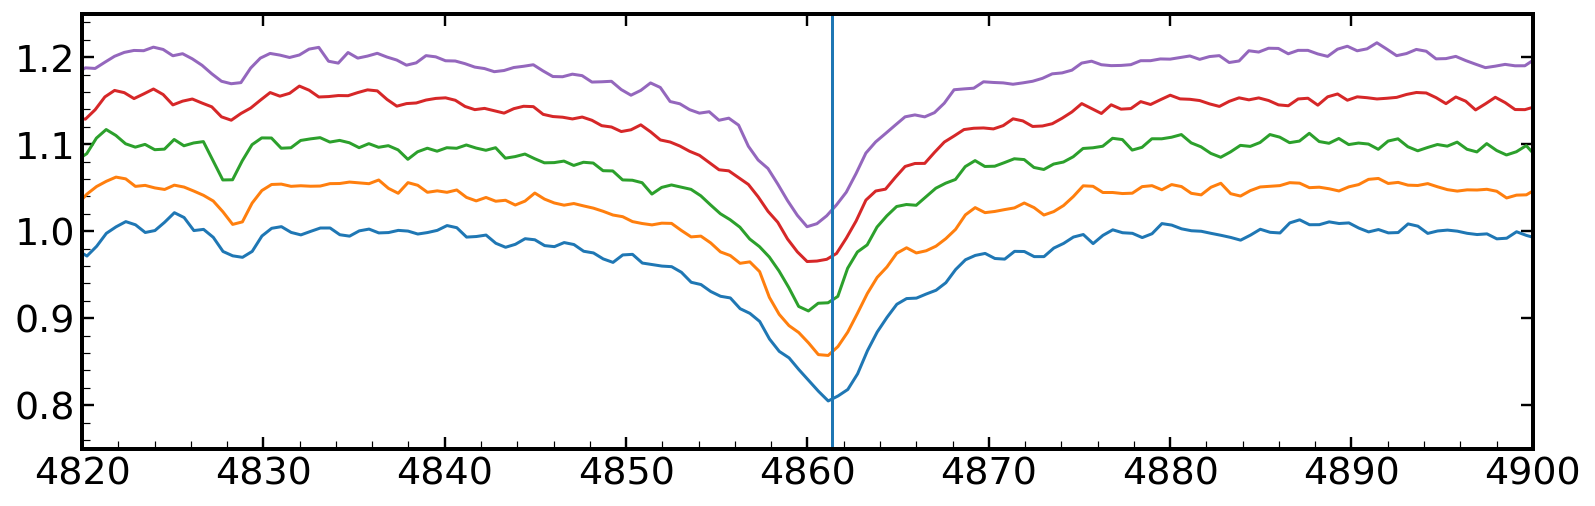

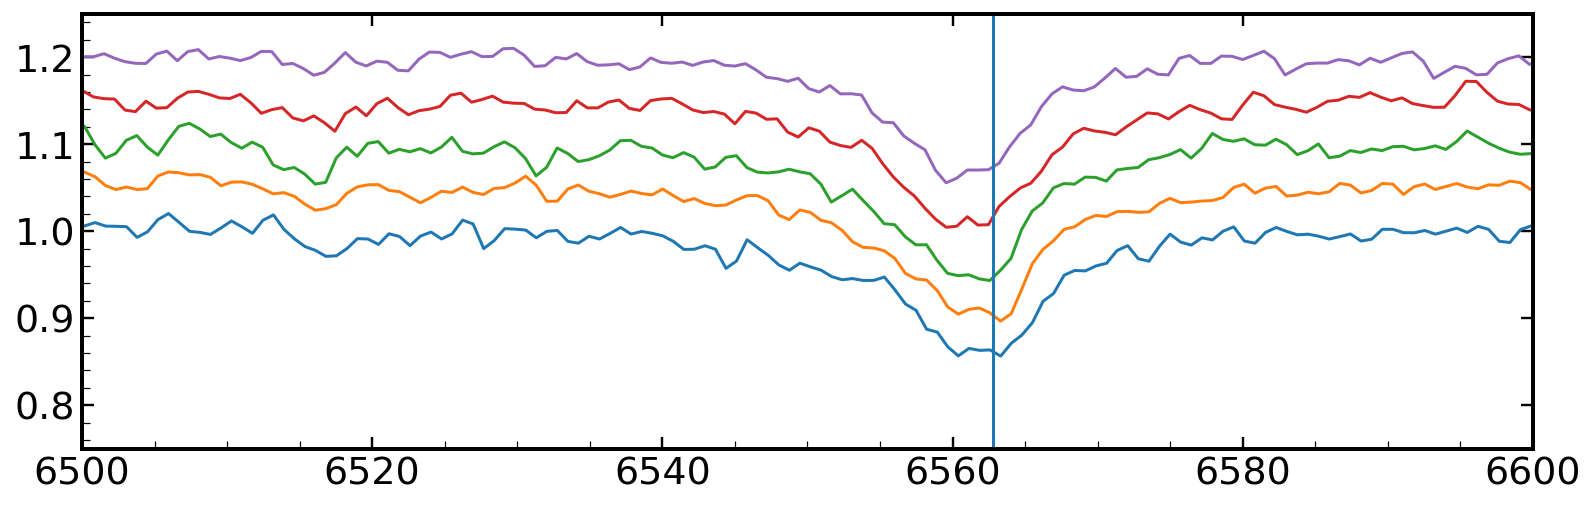

In [65]:
#BD+25 4655 HIP 108578
ra, dec = 329.9248964540986, +26.4326106545684
angdist2BD = pyasl.getAngDist(ra, dec, tab_rv['ra_deg'], tab_rv['dec_deg'])
ind = angdist2BD < 50/3600
tab_rv[ind]
dflux = 0.05
fig, ax = plt.subplots(1,1,figsize=[13,4])
ax = plot_spectra(tab_rv[ind]['basename'], dflux= dflux, dire = '/home/lcq/media/backup/216BFOSC/sdOB_216/', ax=ax)
plt.xlim(4300, 4400)
plt.ylim(0.75, 1.25)
plt.axvline(x=4340.46)
fig, ax = plt.subplots(1,1,figsize=[13,4])
ax = plot_spectra(tab_rv[ind]['basename'],  dflux= dflux, dire = '/home/lcq/media/backup/216BFOSC/sdOB_216/', ax=ax)
plt.xlim(4820, 4900)
plt.ylim(0.75, 1.25)
plt.axvline(x=4861.35)
fig, ax = plt.subplots(1,1,figsize=[13,4])
ax = plot_spectra(tab_rv[ind]['basename'],  dflux= dflux, dire = '/home/lcq/media/backup/216BFOSC/sdOB_216/', ax=ax)
plt.xlim(6500, 6600)
plt.ylim(0.75, 1.25)
plt.axvline(x=6562.79)  

In [66]:
tab_rv[ind]

basename,bjd,ra,dec,ra_deg,dec_deg,flamp,rms_lamp,rv_ccf,err_ccf,rv_halpha,rverr_halpha,rv_hbeta,rverr_hbeta,rv_hgamma,rverr_hgamma
str73,float64,str11,str12,float64,float64,str48,float64,float64,float64,float64,float64,float64,float64,float64,float64
202110220019_SPECSTARGET_BD+25d4655_slit16s_G10_E9_splicing.fits,2459509.929557662,21:59:42.0,+26:25:58.01,329.925,26.432781,202110220021_SPECSLAMP_FeAr_slit16s_G10_E9,0.4176530038082687,-6.760117,3.7474694,-62.468647,7.065024,-36.82691,4.1876974,-26.224003,5.6170077
202110230012_SPECSTARGET_BD25d4655_slit16s_G10_E9_splicing.fits,2459510.927588768,21:59:42.0,+26:25:58.01,329.925,26.432781,202110230014_SPECSLAMP_FeAr_slit16s_G10_E9,0.4138497161339371,-28.808012,5.213509,-94.47146,5.2030625,-57.42765,4.0911074,-58.267788,5.382109
202110240022_SPECSTARGET_BD+25d4655_slit16s_G10_E9_splicing.fits,2459511.994885566,21:59:42.0,+26:25:58.01,329.925,26.432781,202110240024_SPECSLAMP_FeAr_slit16s_G10_E9,0.3334070130790677,-49.756153,6.119622,-105.44408,6.535152,-81.98147,3.8677306,-54.669266,6.7580395
202111130021_SPECSTARGET_BD+25d4655_slit16s_G10_E9_splicing.fits,2459531.921949778,21:59:42.0,+26:25:58.01,329.925,26.432781,202111130022_SPECSLAMP_FeAr_slit16s_G10_E9,0.05600514286129812,-41.89609,3.6808462,-99.28102,5.2123313,-63.49525,2.737249,-66.34296,7.4343567
202111140029_SPECSTARGET_BD+25d4655_slit16s_G10_E9_splicing.fits,2459532.918100307,21:59:40.0,+26:25:58.12,329.91666,26.432812,202111140030_SPECSLAMP_FeAr_slit16s_G10_E9,0.06011775644809996,-50.0,2.8044438,-106.84381,4.9638624,-70.21078,3.0205052,-72.57225,7.6557937


(6500.0, 6600.0)

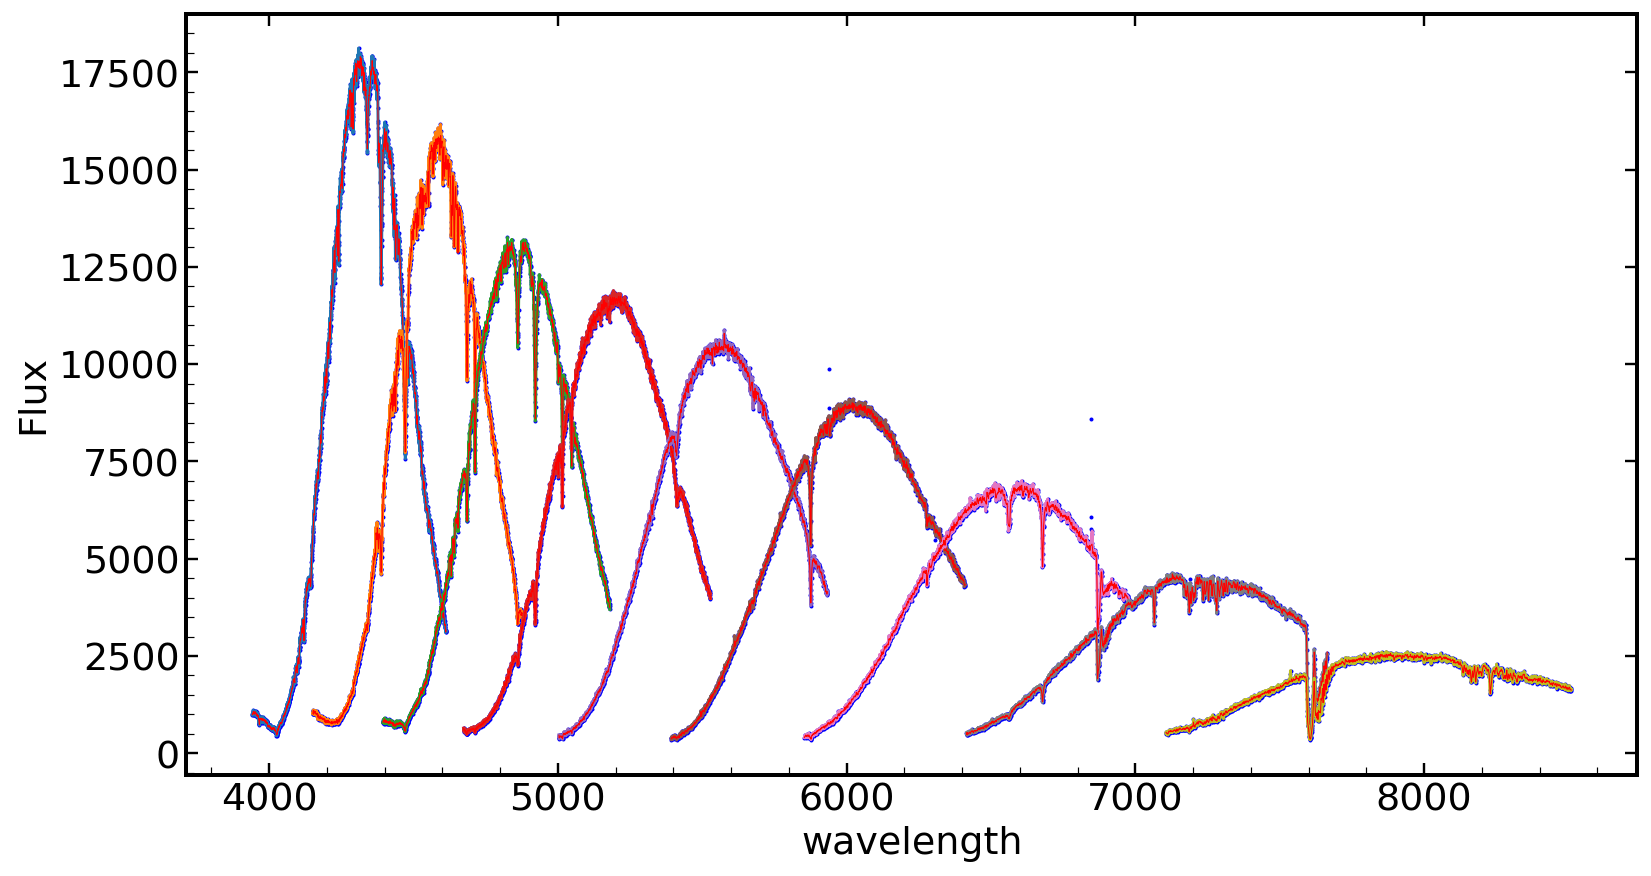

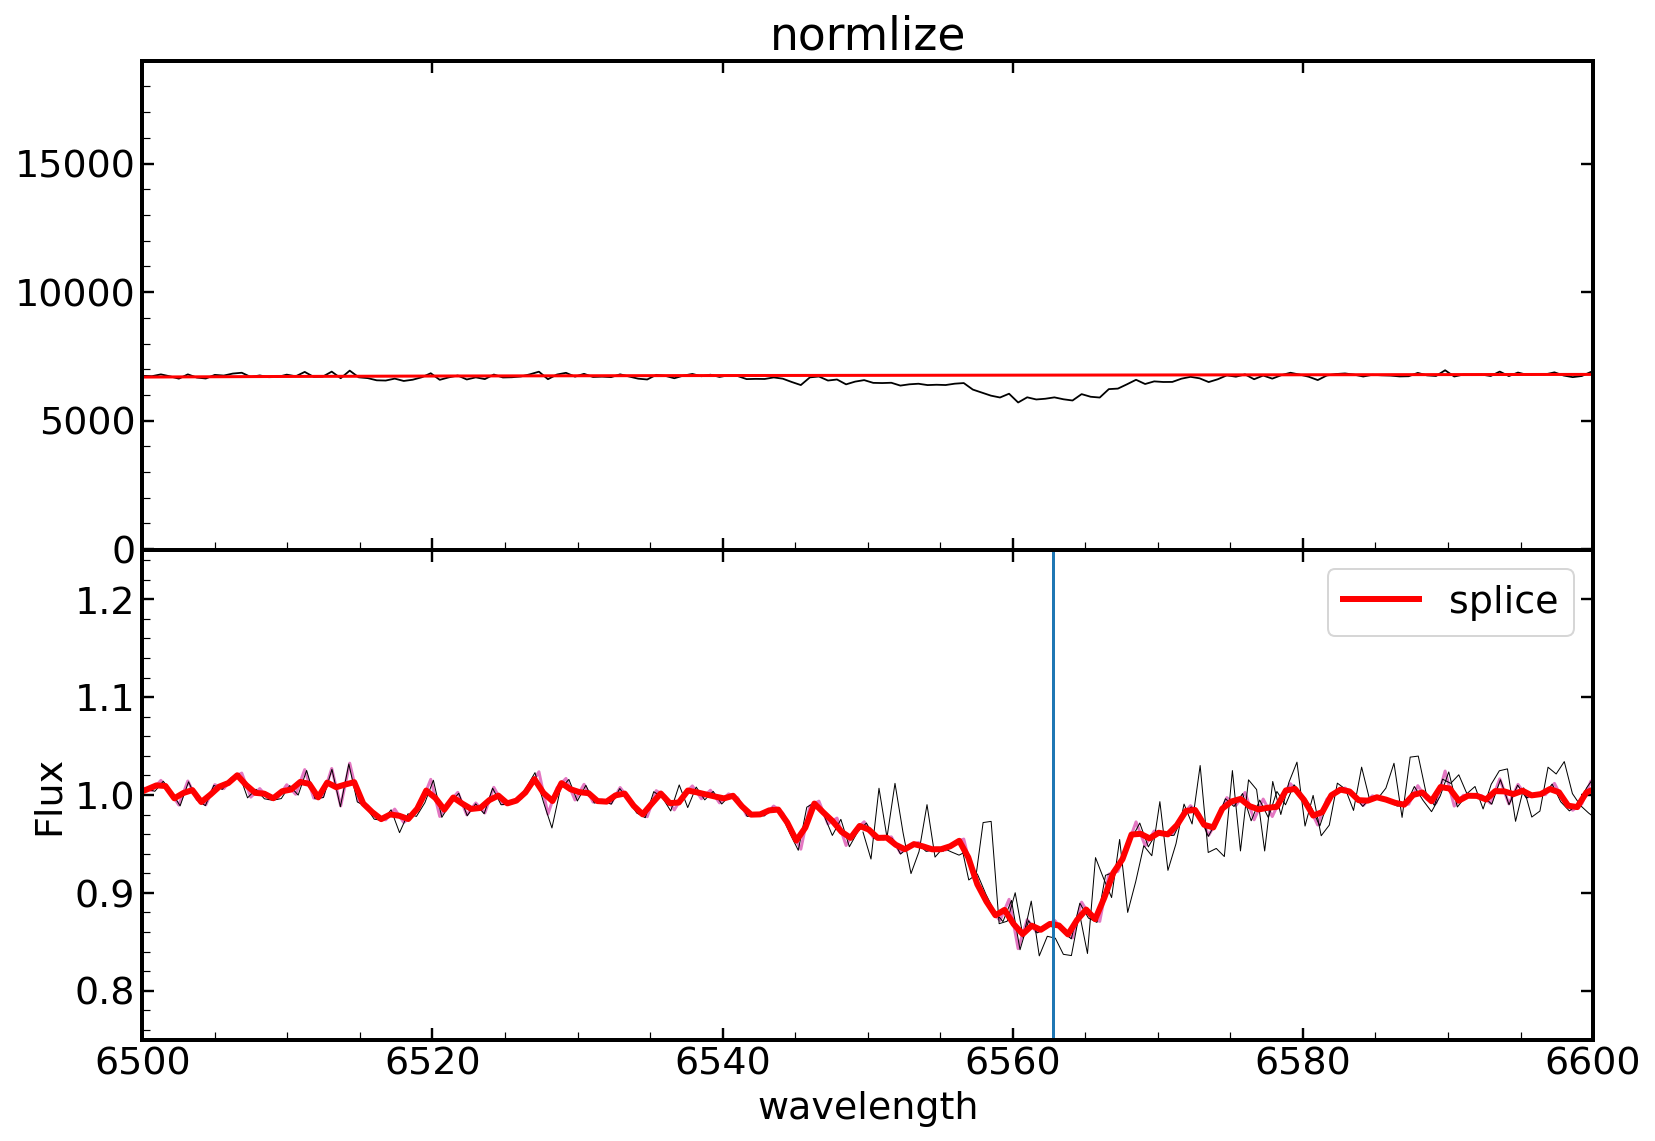

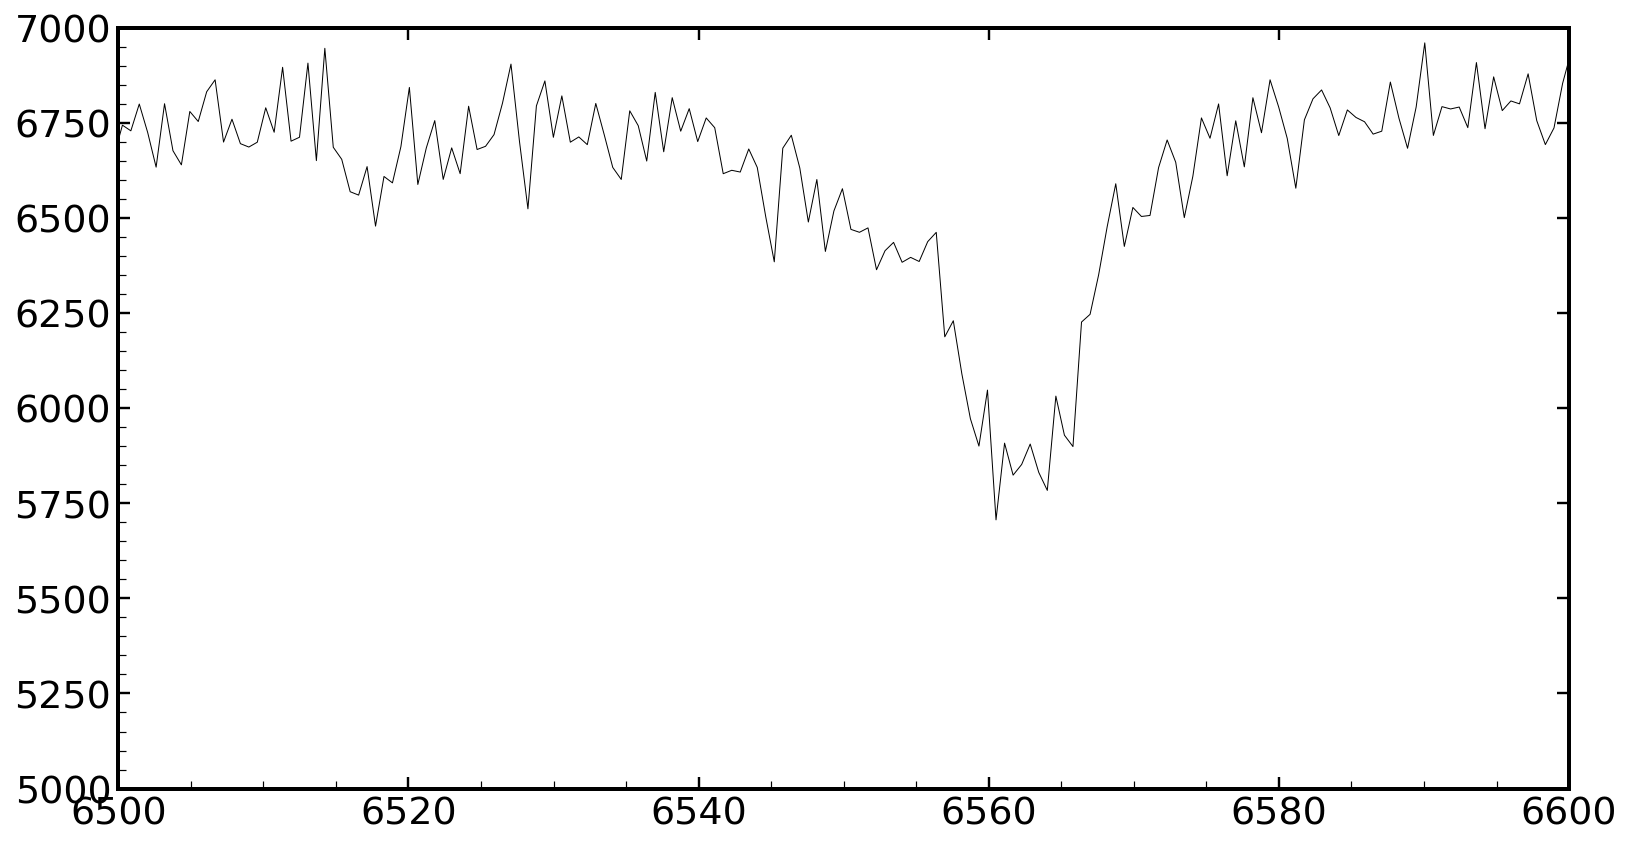

In [64]:
def funcnorm(wave, flux, show=False):
    flux_norm, flux_smoothed =lanorm.normalize_spectrum_spline(wave, flux, p=1E-5, q=0.5, lu=(-1, 3), binwidth=150, niter=5)
    if show:
       plt.plot(wave, flux)
       plt.plot(wave, flux_smoothed)
    return flux_norm, flux_smoothed

fig, ax = plt.subplots(1,1, figsize=[13,7])
dire = '/home/lcq/media/backup/216BFOSC/sdOB_216/'
fitsname = '202110220019_SPECSTARGET_BD+25d4655_slit16s_G10_E9_splicing.fits'
_dire = os.path.join(dire, fitsname[0:8]+'_bfosc')
fullfitsname = os.path.join(_dire, fitsname)
header = fits.getheader(fullfitsname)
flamp, fstar = header['flamp'], header['fstar']
fwave, fflux, starfit, lampfit = bfosce9g10.dumpname(flamp, fstar, _dire)
star = splicing_spectrum.combine_wave_flux(fwave, fflux)
waves = star['wavelength']['wave_solu']
fluxs = star['flux']['spec_extr']
flux_errs = star['flux']['err_extr']
blaze = star['flux']['blaze']
logwave, flux, flux_err = splicing_spectrum.splicing_spectrum(fwave, fflux, R=3500, N=3, lam_start=3700, lam_end=8900, 
                                                              pix=[300, 1900], orders=np.arange(0, 7), funcnorm=funcnorm, 
                                                               divide_blaze=False, threshold_blaze=10, pixorders= None,
                                                              show=True, ax=ax)
for _i, wave in enumerate(waves):
    flux_norm, flux_smoothed = funcnorm(wave, fluxs[_i])
    plt.plot(wave[250:1950], flux_norm[250:1950], 'k', lw=0.5)


#fig, ax = plt.subplots(1,1, figsize=[13,7])
plt.plot(10**logwave, flux, color='r', label='splice', lw=3)
plt.legend()
plt.xlim(6500, 6600)
plt.ylim(0.75, 1.25)
plt.axvline(x=6562.79)  

fig, ax = plt.subplots(1,1, figsize=[13,7])
for _i, wave in enumerate(waves):
    flux_norm, flux_smoothed = funcnorm(wave, fluxs[_i])
    plt.plot(wave[250:1950], fluxs[_i][250:1950], 'k', lw=0.5)

plt.ylim(5000, 7000)
plt.xlim(6500, 6600)

In [42]:
fullname

'/home/lcq/media/backup/216BFOSC/sdOB_216/20211114_bfosc//rv_tab.csv'